# LeNet-5

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datetime import datetime
from torchvision import datasets, transforms

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("now device >> " , DEVICE)

now device >>  cpu


# parameters

In [3]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## transforms 정의 

In [4]:
trasnform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor()])

## 데이터 다운로드, data loader 

In [5]:
train_dataset = datasets.MNIST(root = "./mist_data", train=True, transform = trasnform, download = True)
valid_dataset = datasets.MNIST(root = "./mist_data", train=False, transform = trasnform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 불러온 데이터 확인

C:\Users\bomi\anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


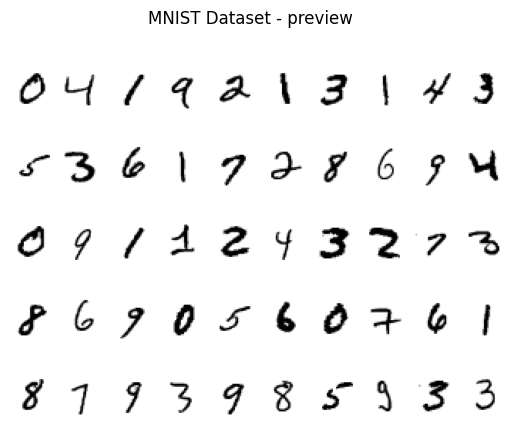

In [6]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1) : 
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle("MNIST Dataset - preview")
fig.show()

## LeNet5 모델 정의

In [7]:
class LeNet5(nn.Module) : 
    def __init__(self, n_classes) : 
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
    
    def forward(self, x) :
        x = self.feature_extractor(x) 
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### acc 구하는 함수 구현 

In [8]:
def get_accuracy(model, data_loader, device) : 
    correct_pred = 0
    n = 0 
    
    with torch.no_grad() :
        for X, y_true in data_loader :
            X = X.to(device)
            y_true = y_true.to(device)
            
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
            
    return correct_pred.float() / n

In [9]:
def plot_losses(train_losses, valid_losses):
    plt.style.use('seaborn')
    
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", xlabel="Epoch", ylabel="Loss")
    ax.legend()
    fig.show()
    
    plt.style.use('default')

In [10]:
def train(train_loader, model, criterion, optimizer, device) : 
    model.train()
    runing_loss = 0 
    
    for X, y_true in train_loader : 
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
        
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true)
        runing_loss += loss.item() * X.size(0)
        
        loss.backward()
        optimizer.step()
        
    epoch_loss = runing_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [11]:
def validata(valid_loader, model, criterion, device) : 
    model.eval()
    runing_loss = 0 
    
    for X, y_true in valid_loader : 
        X = X.to(device)
        y_true = y_true.to(device)
        
        # 순전파와 손실 기록 
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        runing_loss += loss.item() * X.size(0)
        
    epoch_loss = runing_loss / len(valid_loader.dataset)
    
    return model, epoch_loss

## 학습 loop

In [12]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1) : 
    
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    
    for epoch in range(0, epochs) : 
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        with torch.no_grad() : 
            model, valid_loss = validata(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            
        if epoch % print_every == (print_every - 1) : 
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} ---'
                  f'Epoch : {epoch + 1}\t'
                  f'Train loss : {train_loss:.4f}\t'
                  f'Valid loss : {valid_loss:.4f}\t'
                  f'Train accuracy : {100 * train_acc:.2f}\t'
                  f'Valid accuracy : {100 * valid_acc:.2f}')
            
    plot_losses(train_losses, valid_losses)
            
    return model, optimizer, (train_losses, valid_losses)

11:28:48 ---Epoch : 1	Train loss : 0.2290	Valid loss : 0.1020	Train accuracy : 96.84	Valid accuracy : 96.81
11:33:14 ---Epoch : 2	Train loss : 0.0762	Valid loss : 0.0619	Train accuracy : 98.39	Valid accuracy : 98.19
11:37:40 ---Epoch : 3	Train loss : 0.0550	Valid loss : 0.0542	Train accuracy : 98.59	Valid accuracy : 98.45
11:42:03 ---Epoch : 4	Train loss : 0.0438	Valid loss : 0.0486	Train accuracy : 99.07	Valid accuracy : 98.41
11:46:24 ---Epoch : 5	Train loss : 0.0343	Valid loss : 0.0416	Train accuracy : 99.24	Valid accuracy : 98.74
11:51:37 ---Epoch : 6	Train loss : 0.0299	Valid loss : 0.0422	Train accuracy : 99.40	Valid accuracy : 98.76
11:56:53 ---Epoch : 7	Train loss : 0.0244	Valid loss : 0.0436	Train accuracy : 99.42	Valid accuracy : 98.52
12:03:31 ---Epoch : 8	Train loss : 0.0220	Valid loss : 0.0464	Train accuracy : 99.43	Valid accuracy : 98.59
12:09:55 ---Epoch : 9	Train loss : 0.0186	Valid loss : 0.0429	Train accuracy : 99.64	Valid accuracy : 98.66
12:15:49 ---Epoch : 10	Train

C:\Users\bomi\anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


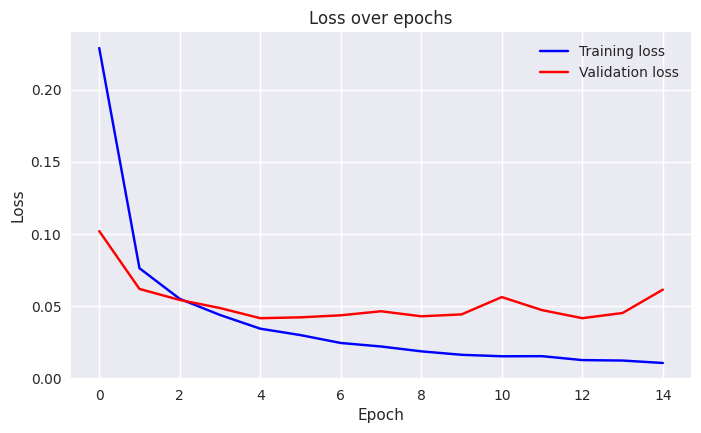

In [13]:
if __name__ == "__main__":
    torch.manual_seed(RANDOM_SEED)
    
    model = LeNet5(N_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)